# Transfer learning with Inception V3

In [1]:

import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-04-26 21:03:27.934959: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 21:03:27.959184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 21:03:27.959205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 21:03:27.959778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 21:03:27.964005: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 21:03:27.964638: I tensorflow/core/platform/cpu_feature_guard.cc:1

Found 1003 files belonging to 2 classes.
Using 803 files for training.
Using 200 files for validation.


2024-04-26 21:03:31.986679: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-26 21:03:31.986925: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


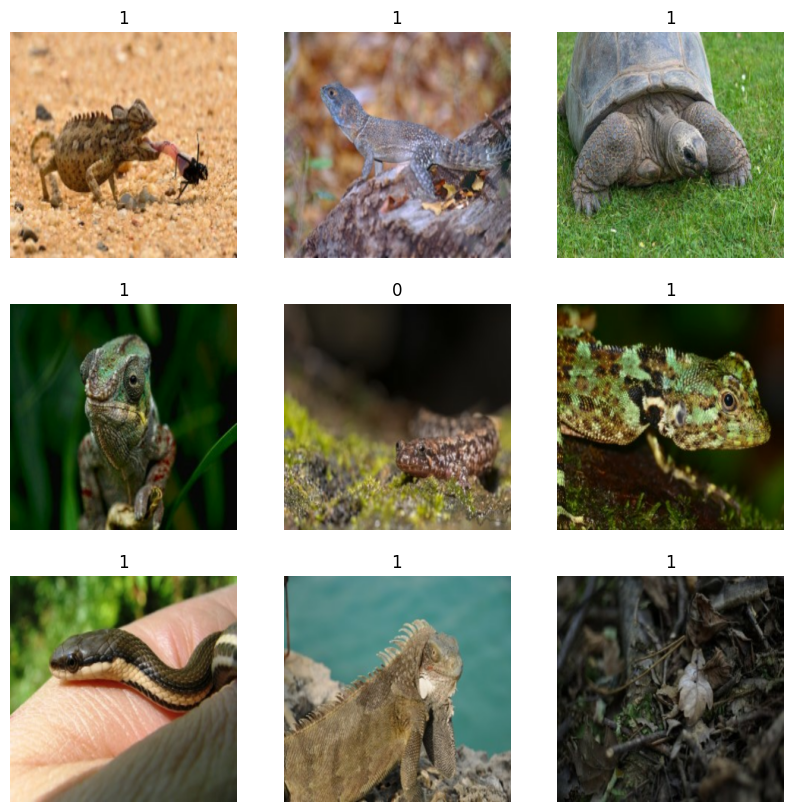

In [2]:
import DataLoader

train_ds, val_ds = DataLoader.load_image_dataset("reptile_amphibian_pics")

DataLoader.show_images(train_ds)


In [3]:
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
import keras

def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of InceptionV3 and freeze the weights
    backbone = InceptionV3(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    # input layer and InceptionV3 backbone and dropout
    inputs = keras.Input(input_shape)
    x = keras.applications.inception_v3.preprocess_input(inputs)
    x = backbone(x)
    x = Dropout(0.3)(x)

    # global average pooling layer
    x = GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    # another dropout
    x = Dropout(0.25)(x)

    # We specify activation=None so as to return logits
    outputs = Dense(units, activation=None)(x)

    # Define the model
    model_3 = Model(inputs, outputs, name="transfer_model")

    return model_3

# Create the transfer model
image_size = (299, 299)  # InceptionV3 requires input shape to be (299, 299)
model_3 = make_transfer_model(input_shape=image_size + (3,), num_classes=2)


In [4]:
epochs =10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model_3.compile(
    optimizer=keras.optimizers.legacy.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model_3.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
81/81 [==============================] - 35s 404ms/step - loss: 0.5492 - acc: 0.7098 - val_loss: 0.3640 - val_acc: 0.9250
Epoch 2/10
81/81 [==============================] - 33s 412ms/step - loss: 0.3238 - acc: 0.9178 - val_loss: 0.2670 - val_acc: 0.9250
Epoch 3/10
81/81 [==============================] - 37s 453ms/step - loss: 0.2449 - acc: 0.9440 - val_loss: 0.2305 - val_acc: 0.9250
Epoch 4/10
81/81 [==============================] - 39s 484ms/step - loss: 0.2084 - acc: 0.9452 - val_loss: 0.2121 - val_acc: 0.9300
Epoch 5/10
81/81 [==============================] - 38s 473ms/step - loss: 0.1841 - acc: 0.9489 - val_loss: 0.1999 - val_acc: 0.9350
Epoch 6/10
81/81 [==============================] - 37s 462ms/step - loss: 0.1681 - acc: 0.9514 - val_loss: 0.1941 - val_acc: 0.9400
Epoch 7/10
81/81 [==============================] - 39s 478ms/step - loss: 0.1606 - acc: 0.9564 - val_loss: 0.1884 - val_acc: 0.9400
Epoch 8/10
81/81 [==============================] - 37s 452ms/step - 

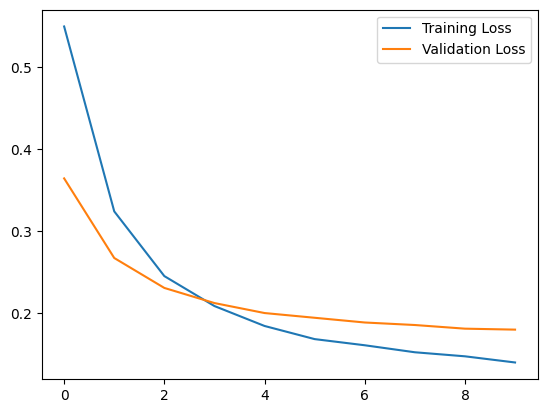

In [5]:

plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

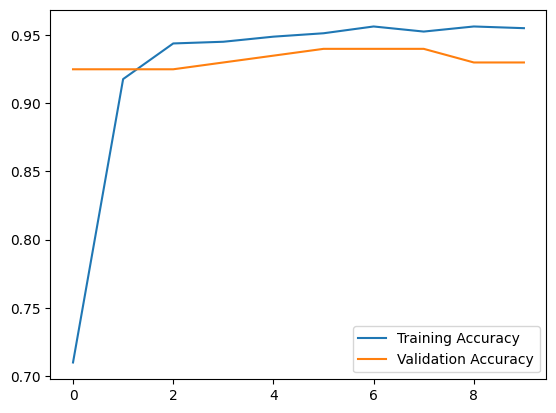

In [6]:

plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.legend()

In [7]:
# Save the model with keras
model_3.save("my_model5.keras")

# Data Augmentation
+ Random Flip and Rotation from Dr.Farbin's example
+ Random Translation
+ Random Zoom

In [8]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), 
    layers.RandomZoom(height_factor=0.4, width_factor=0.4),]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

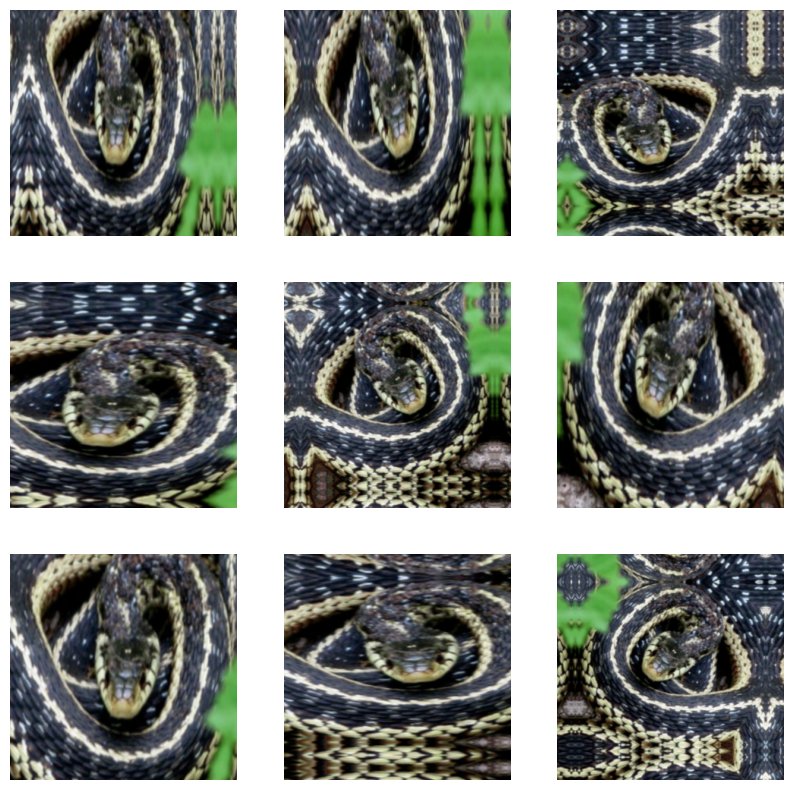

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [10]:
augmented_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
val_augmented_ds = val_ds.map(lambda x, y: (data_augmentation(x), y))

In [11]:
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model on augmented dataset
history = model_3.fit(augmented_ds, validation_data=val_augmented_ds, epochs=10)  # Adjust epochs as needed


Epoch 1/10
81/81 [==============================] - 35s 398ms/step - loss: 0.8265 - accuracy: 0.9265 - val_loss: 0.9701 - val_accuracy: 0.9150
Epoch 2/10
81/81 [==============================] - 35s 434ms/step - loss: 1.0712 - accuracy: 0.9004 - val_loss: 0.9253 - val_accuracy: 0.9100
Epoch 3/10
81/81 [==============================] - 37s 461ms/step - loss: 0.8785 - accuracy: 0.9128 - val_loss: 1.2504 - val_accuracy: 0.9050
Epoch 4/10
81/81 [==============================] - 40s 497ms/step - loss: 3.0550 - accuracy: 0.7235 - val_loss: 1.3653 - val_accuracy: 0.8850
Epoch 5/10
81/81 [==============================] - 41s 501ms/step - loss: 0.7527 - accuracy: 0.9303 - val_loss: 0.7779 - val_accuracy: 0.9450
Epoch 6/10
81/81 [==============================] - 40s 489ms/step - loss: 0.7445 - accuracy: 0.9303 - val_loss: 0.8135 - val_accuracy: 0.9150
Epoch 7/10
81/81 [==============================] - 39s 478ms/step - loss: 0.8755 - accuracy: 0.9265 - val_loss: 0.8920 - val_accuracy: 0.9250

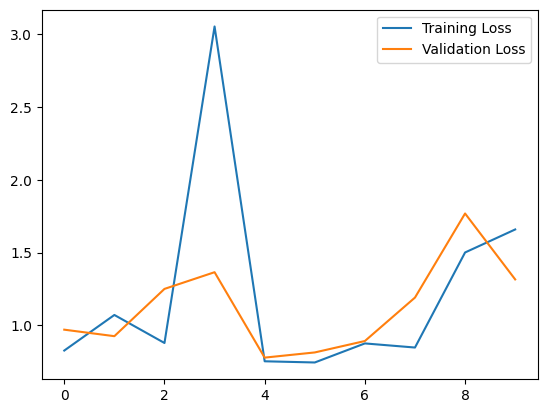

In [12]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

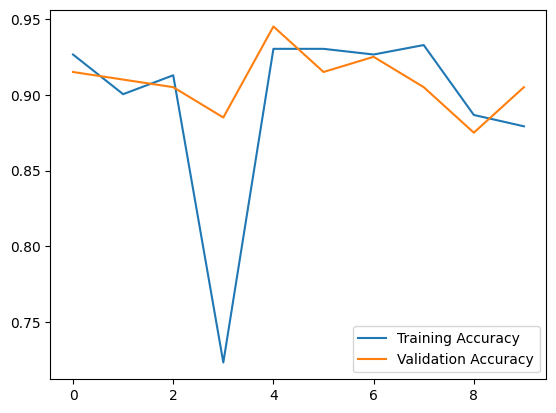

In [13]:
plt.plot(range(len(history.history["accuracy"])),history.history["accuracy"],label="Training Accuracy")
plt.plot(range(len(history.history["val_accuracy"])),history.history["val_accuracy"],label="Validation Accuracy")
plt.legend()

In [14]:
model_3.save("my_model6.keras")

# Comparisons

**Model trained without augmented data**  
final training accuracy: 0.9552 and training loss: 0.1396
final val accuracy: 0.9300 and val loss: 0.1797

+ This model has good accuracy and low loss values. It is performing very well.

**Model trained with augmented data**  
final training accuracy: 0.8792 and training loss: 1.6591
final val accuracy: 0.9050 and val loss: 1.3157

+ For this model the accuracy is good but not as high as the first model. However, the loss and accuracy curves are jumping around from high to low which indicates that the model is not handling the augmented images very well. More hyperparameter tuning should be done such as adjusting the batch size, etc.

The model trained on the original image dataset ended with a higher training accuracy as well as a lower loss value, indicating that without using augmented data for training, the transfer learning model performed better. 
